# Experiments Gaussian optimal Transport in Very High Dimensions
DenseICNNs for fitting transport maps between Gaussians.
**GPU-only implementation.**

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
torch.random.manual_seed(0xBADBEEF)

from scipy.stats import ortho_group
from scipy.linalg import sqrtm

from src.icnn import DenseICNN
from src.tools import compute_l1_norm, ewma
from src.fid_score import calculate_frechet_distance
from src import distributions

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

## Config

In [2]:
DIM = 1024
assert DIM > 1

OUTPUT_SEED = 0xC0FFEE
L1 = 1e-10
GPU_DEVICE = 2
BATCH_SIZE = 256
LAMBDA = min(DIM, 50)
LR = 3 * 1e-4

In [3]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## Initialize Gaussians
For high dimensions (e.g. 4096), computation of ground truth OT maps and distances may takes few hours (it requires inverting very large matrix). Also, for large dimensions batch size reduction is recommended.

In [4]:
np.random.seed(OUTPUT_SEED)
torch.manual_seed(OUTPUT_SEED)

rotation_Y = ortho_group.rvs(DIM)
weight_Y = rotation_Y @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), DIM)))
sigma_Y = weight_Y @ weight_Y.T
Y_sampler = distributions.LinearTransformer(weight_Y, bias=None, requires_grad=True)
Y_sampler.fit(distributions.StandartNormalSampler(dim=DIM))

rotation_X = ortho_group.rvs(DIM)
weight_X = rotation_X @ np.diag(np.exp(np.linspace(np.log(0.5), np.log(2), DIM)))
sigma_X = weight_X @ weight_X.T
X_sampler = distributions.LinearTransformer(weight_X, bias=None, requires_grad=True)
X_sampler.fit(distributions.StandartNormalSampler(dim=DIM))

BW = calculate_frechet_distance(np.zeros(DIM), sigma_X, np.zeros(DIM), sigma_Y) / 2
print('True Wasserstein-2 Distance: ', BW)

X = X_sampler.sample(100000).cpu().detach().numpy()
Var_X = np.sum(np.var(X, axis=0))
print('Variance of X:', Var_X)
      
Y = Y_sampler.sample(100000).cpu().detach().numpy()
Var_Y = np.sum(np.var(Y, axis=0))
print('Variance of Y:', np.sum(Var_Y))

torch.cuda.empty_cache()

True Wasserstein-2 Distance:  180.0493504018043
Variance of X: 1385.5864
Variance of Y: 1385.898


In [5]:
def symmetrize(X):
    return np.real((X + X.T) / 2)

root_sigma_X = symmetrize(sqrtm(sigma_X))
inv_root_sigma_X = symmetrize(np.linalg.inv(root_sigma_X))

map_XY = inv_root_sigma_X @ symmetrize(sqrtm(root_sigma_X @ sigma_Y @ root_sigma_X)) @ inv_root_sigma_X

root_sigma_Y = symmetrize(sqrtm(sigma_Y))
inv_root_sigma_Y = symmetrize(np.linalg.inv(root_sigma_Y))

map_YX = inv_root_sigma_Y @ symmetrize(sqrtm(root_sigma_Y @ sigma_X @ root_sigma_Y)) @ inv_root_sigma_Y

## Discriminators Setup

In [6]:
D = DenseICNN(
    DIM, rank=1, hidden_layer_sizes=[max(128, DIM), max(128, DIM), max(64, DIM)],
    dropout=0, strong_convexity=5 * 1e-2
).cuda()

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

# Manual weights init
for p in D.parameters():
    p.data = torch.randn(p.shape, device='cuda', dtype=torch.float32) / 20.

8392704 parameters in Discriminative Network


Discriminator pretraining to satisfy $\nabla\psi_{\theta}(x)\approx x$.

In [7]:
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.8, 0.9))

D.train(True)
loss = np.inf
BLOW = 3

for iteration in tqdm(range(10000)):
    X = ((X_sampler.sample(BATCH_SIZE)) * BLOW).detach()
    X.requires_grad_(True)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean() + L1 * compute_l1_norm(D)
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    D.convexify()
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < .3 * 1e-4:
        clear_output(wait=True)
        break
print('Final Loss:', loss.item())

 95%|█████████▌| 9512/10000 [01:46<00:05, 90.49it/s]

Pretraining the discriminator for D.push(x)=x
Current loss: 14.359827041625977


100%|██████████| 10000/10000 [01:51<00:00, 89.38it/s]

Final Loss: 4.952290058135986


In [8]:
D_conj = DenseICNN(
    DIM, rank=1, hidden_layer_sizes=[max(128, DIM), max(128, DIM), max(64, DIM)],
    dropout=0., strong_convexity=5 * 1e-2
).cuda()
D_conj.load_state_dict(D.state_dict())

<All keys matched successfully>

## PCA

In [9]:
pca = PCA(n_components=2)
pca.fit(Y_sampler.sample(100000).cpu().detach().numpy())

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Main training

In [10]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.4, 0.4))

In [11]:
loss_history = []

UVP_forward_history = []
UVP_inverse_history = []

In [12]:
plot_batchsize = 1000
s = None
figsize = (18, 4.5)

plot_every = 1000
max_iter = 5001

score_every = 100
score_batchsize = 1024

Iteration 5000


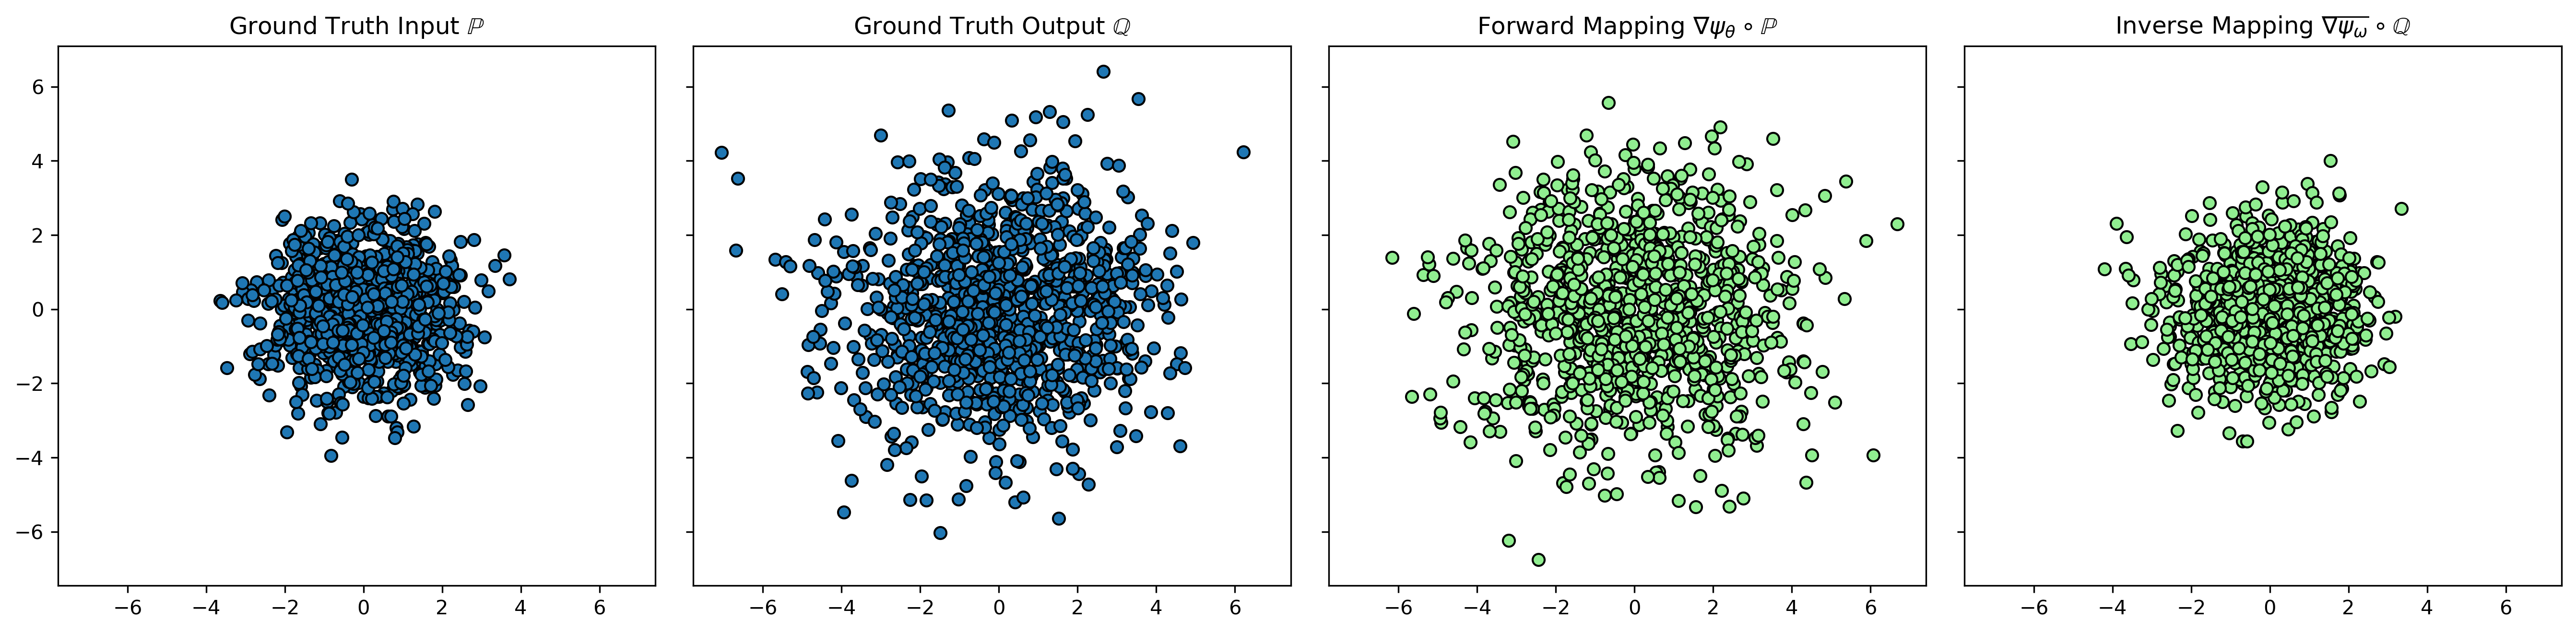

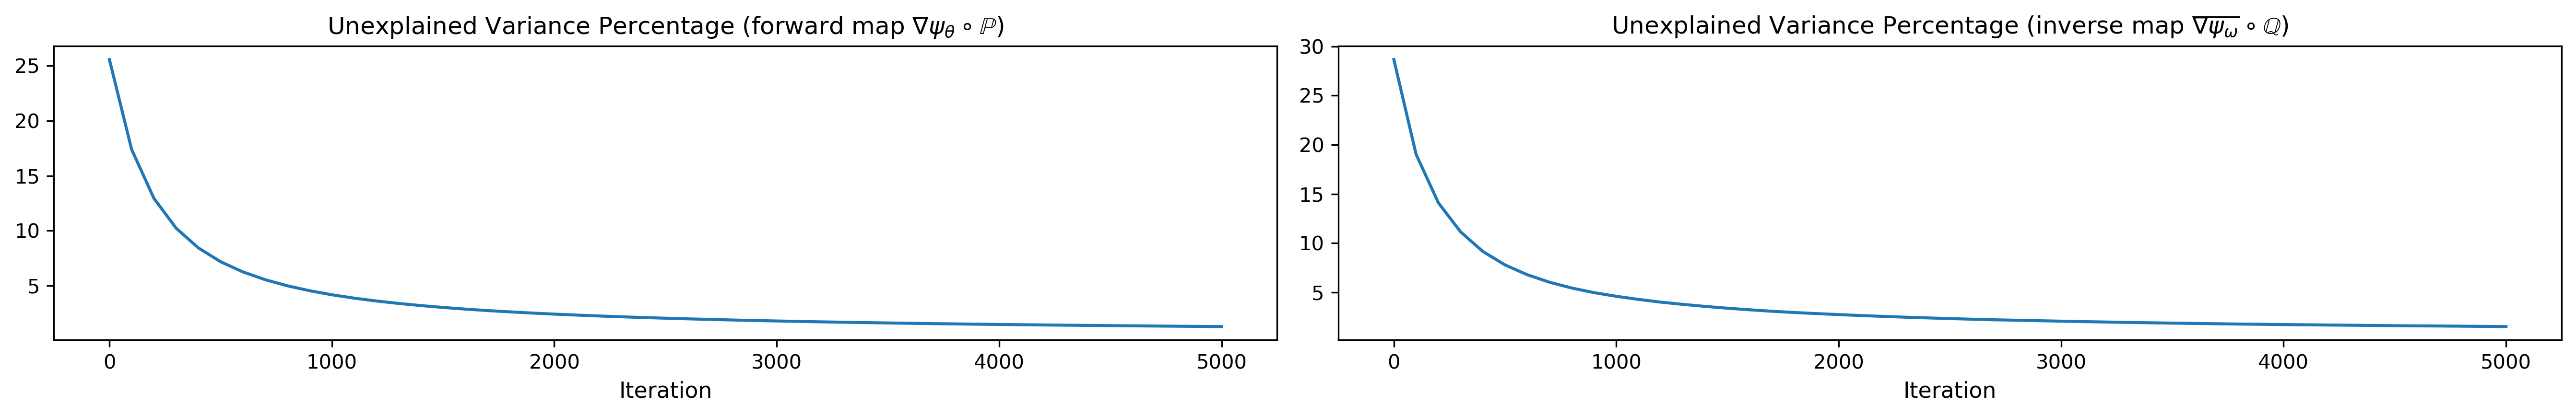

In [13]:
print('Fitting the monotone generative mapping')
for iteration in range(max_iter):
    D.train(True); D_conj.train(True)
    
    X = X_sampler.sample(BATCH_SIZE)
    Y = Y_sampler.sample(BATCH_SIZE)
    
    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad(); D_conj_opt.zero_grad()    
    W_loss = (D(X) - D(Y_inv)).mean()
    # Non-backpropagated part
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
    
    # Weight L1 regularization
    D_reg = compute_l1_norm(D)
    D_conj_reg = compute_l1_norm(D_conj)
    W_loss += L1 * (D_reg + D_conj_reg)
    
    # Cycle Regularization
    cycle_loss_YXY = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    cycle_loss_XYX = ((D_conj.push(D.push(X)) - X.detach()) ** 2).mean()
    W_loss += LAMBDA * (cycle_loss_XYX + cycle_loss_YXY)
    
    loss_history.append(W_loss.item() + W_loss_nograd.item())

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad() 
    D.convexify(); D_conj.convexify()  
         
    # Scores estimate without dropout and by using more projections;
    if iteration % score_every == 0:
        D.train(False); D_conj.train(True)
        Y = Y_sampler.sample(score_batchsize)
        X = X_sampler.sample(score_batchsize)
        X_push = D.push(X).cpu().detach().numpy()
        Y_push = D_conj.push(Y).cpu().detach().numpy()
        
        L2_inverse = np.sum((Y_push - (map_YX @ Y.cpu().detach().numpy().T).T) ** 2, axis=1).mean()
        L2_forward = np.sum((X_push - (map_XY @ X.cpu().detach().numpy().T).T) ** 2, axis=1).mean()
        
        UVP_forward_history.append(100 * L2_forward / Var_Y)
        UVP_inverse_history.append(100 * L2_inverse / Var_X)
        
        D.train(True); D_conj.train(True)
            
    if iteration % plot_every == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        D.train(False); D_conj.train(False)
    
        fig, axes = plt.subplots(1, 4, figsize=figsize, dpi=300, sharex=True, sharey=True)
        Y = Y_sampler.sample(plot_batchsize)
        X = X_sampler.sample(plot_batchsize)
        X_push = pca.transform(D.push(X).cpu().detach().numpy())
        Y_push = pca.transform(D_conj.push(Y).cpu().detach().numpy())
        X = pca.transform(X.cpu().detach().numpy())
        Y = pca.transform(Y.cpu().detach().numpy())

        axes[0].scatter(X[:, 0], X[:, 1], edgecolors='black', s=s)
        axes[1].scatter(Y[:, 0], Y[:, 1], edgecolors='black', s=s)
        axes[2].scatter(X_push[:, 0], X_push[:, 1], c='lightgreen', edgecolors='black', s=s)
        axes[3].scatter(Y_push[:, 0], Y_push[:, 1], c='lightgreen', edgecolors='black', s=s)

        axes[0].set_title(r'Ground Truth Input $\mathbb{P}$', fontsize=12)
        axes[1].set_title(r'Ground Truth Output $\mathbb{Q}$', fontsize=12)
        axes[2].set_title(
            r'Forward Mapping $\nabla\psi_{\theta}\circ\mathbb{P}$',
            fontsize=12
        )
        axes[3].set_title(
            r'Inverse Mapping $\nabla\overline{\psi_{\omega}}\circ\mathbb{Q}$',
            fontsize=12
        )
        fig.tight_layout()
                
        plt.show()
        plt.close(fig)
        D.train(True); D_conj.train(True)
        
        fig, axes = plt.subplots(1, 2, figsize=(figsize[0], 3), sharex=True, dpi=300)
        
        axes[0].plot(
            range(0, score_every * len(UVP_forward_history), score_every),
            ewma(UVP_forward_history, span=100)
        )
        axes[0].set_title(r'Unexplained Variance Percentage (forward map $\nabla\psi_{\theta}\circ\mathbb{P}$)', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        
        axes[1].plot(
            range(0, score_every * len(UVP_inverse_history), score_every),
            ewma(UVP_inverse_history, span=100)
        )
        axes[1].set_title(
            r'Unexplained Variance Percentage (inverse map $\nabla\overline{\psi_{\omega}}\circ\mathbb{Q}$)',
            fontsize=12
        )
        axes[1].set_xlabel('Iteration', fontsize=11)
        
        fig.tight_layout()
        plt.show()
        plt.close(fig)